# Differences in CDRH3

Here we will make the following figures:

  * CDRH3 length distribution (**Figure 1a**)
  * N1 length distribution (**Figure 1b**)
  * N2 length distribution (**Figure 1c**)
  * D3-J6 frequencies (**Figure 1d**)
  * Native D gene lengths (**Figure 1e**)
  * Frequency of given CDRH3 length or longer (**Figure 1f**)
  
  
The raw data used to make these plots can be found [**here**](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA592154).

The following Python packages are required to run the code in this notebook:
  * numpy
  * pandas
  * scipy
  * matplotlib
  * seaborn
  * biopython
  * [abutils](https://www.github.com/briney/abutils)

They can be install by running `pip install numpy pandas scipy matplotlib seaborn biopython abutils`

In [1]:
import itertools
import os
import sys

import math
import numpy as np
import scipy
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO
#from abutils.utils import mongodb
#from abutils.utils import color

%matplotlib inline

In [24]:
def scale_and_normalize(df):
    '''
    This will scale the read counts for the samples 
    in the same way that DeSeq2 scales RNAseq reads
    and then will perform global normalization.
       - df input is a dataframe with read counts, 
         genes as rows, samples as columns.
    '''
    #First take the log of each read count
    df_log = np.log(df)
    
    #Then calculate the geometric mean across rows
    df_log['geometric mean'] = df_log.mean(axis=1)
    
    #Remove any genes that are not expressed by OmniRats
    df_log = df_log[df_log['geometric mean'] != np.NINF]
    
    #Get rid of the geometric mean column
    df_log = df_log.drop('geometric mean', 1)
    
    #Subtract each value from the mean of its columnn
    df_log = df_log.sub(df_log.mean(axis=1), axis=0)
    
    #Calculate scaling factors
    scaling_factors = []
    for median in list(df_log.median()):
        scaling_factors.append(math.exp(median))
    
    #Divide each column by the scaling factor
    for i, col in enumerate(df.columns):
        sf = scaling_factors[i]
        df[col] = df[col]/sf
        
    #remove where there is no expression
    #df = df[df.index.isin(df_log.index)]
    
    return df

# returns color of line for LN, Spleen or Human
def line_color(column):
    if ' ' in column and 'Spleen' in column:
        return (0.00784313725490196, 0.24313725490196078, 1.0)
        #return '#3333FF'
    elif ' ' in column and 'Spleen' not in column:
        return 'gray'
    else:
        return '#5d5e60'

# CDR3 Length Graph
def cdr3_length_histogram(df, color_dict, line_dict, text_dict, figfile=None, figsize=(6.5, 4),
                          style='white', legend_location='upper right',
                          shade=False, shade_alpha=0.1, legend=True,
                          ylim=(0, 0.16), xlim=(0, 40),
                          label_fontsize=16, tick_fontsize=12, legend_fontsize=10):
    #get subjects
    subjects = list(df.columns)
    
    # initialize the plot
    sns.set_style(style)    
    plt.figure(figsize=figsize)
    
    # plot the data
    for subject in subjects:
        color = color_dict[subject]
        text_height = text_dict[subject]
        line_height = line_dict[subject]
        xs = df.index.values
        ys = df[subject]
        average_len = mean_from_agg(xs, ys)
        plt.plot(xs, ys, c=color, alpha=1, linewidth=2.5, label=subject)
        #, linestyle='--', dashes=(5, 2)
        if shade:
            shade_lower = [0] * len(xs)
            plt.fill_between(x=list(xs), y1=list(shade_lower), y2=list(ys.values), color=color, alpha=0.2)
        plt.axvline(x=average_len, ymin=0, ymax=line_height, color=color, linestyle='dotted')
            # style the plot
        ax = plt.gca()
        ax.text(average_len + 0.03,
                text_height,
                'Mean: {}'.format(round(average_len, 1)),
                color=color,
                fontsize=12,
                horizontalalignment='left')


    # set axis limits and labels
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel('Frequency', fontsize=label_fontsize, labelpad=6)
    ax.set_xlabel('CDR3 length (AA)', fontsize=label_fontsize)
    # style ticks
    locs = ax.get_yticks()
    ax.set_yticks(np.arange(0, 0.2, 0.02))
    ax.set_xticks(np.arange(0, 35, 5))
    ax.tick_params(axis='x', which='major', labelsize=tick_fontsize)
    ax.tick_params(axis='y', which='major', labelsize=tick_fontsize, length=6, width=1.25, pad=6, right=False)
    # hide top, left and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # configure the legend
    if legend:
        all_colors = [(0.00784313725490196, 0.24313725490196078, 1.0), '#696969']
        handles = [plt.Line2D([0,0], [0,0], color=c, marker='o', linestyle='', alpha=1) for c in all_colors]
        labels = ['OmniRat', 'Human']
        ax.legend(handles, labels, loc=legend_location, fontsize=10, 
                  frameon=False, handletextpad=-.1, markerscale=0.75, bbox_to_anchor=(1.1, 1.05))
    
    # save or show
    if figfile is not None:
        plt.tight_layout()
        plt.savefig(figfile, dpi=800)
    else:
        plt.show()
        
# N Length Graph
def n_length_histogram(df, color_dict, line_dict, text_dict, figfile=None, figsize=(6.5, 4),
                          style='white', legend_location='upper right',
                          shade=False, shade_alpha=0.1, legend=True,
                          ylim=(0, 0.16), xlim=(0, 40), xlab = '',
                          label_fontsize=16, tick_fontsize=12, legend_fontsize=10):
    #get subjects
    subjects = list(df.columns)
    
    # initialize the plot
    sns.set_style(style)    
    plt.figure(figsize=figsize)
    
    # plot the data
    for subject in subjects:
        color = color_dict[subject]
        text_height = text_dict[subject]
        line_height = line_dict[subject]
        xs = df.index.values
        ys = df[subject]
        average_len = mean_from_agg(xs, ys)
        plt.plot(xs, ys, c=color, alpha=1, linewidth=2.5, label=subject)
        if shade:
            shade_lower = [0] * len(xs)
            plt.fill_between(x=list(xs), y1=list(shade_lower), y2=list(ys.values), color=color, alpha=0.2)
        
        plt.axvline(x=average_len, ymin=0, ymax=line_height, color=color, linestyle='dotted')
        # style the plot
        ax = plt.gca()
        ax.text(average_len + 0.03,
                text_height,
                'Mean: {}'.format(round(average_len, 1)),
                color=color,
                fontsize=12,
                horizontalalignment='left')
    
    # style the plot
    # set axis limits and labels
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel('Frequency', fontsize=label_fontsize, labelpad=6)
    ax.set_xlabel(xlab, fontsize=label_fontsize)
    # style ticks
    locs = ax.get_yticks()
    ax.set_yticks(np.arange(0, 0.44, 0.04))
    ax.set_xticks(np.arange(0, 30, 5))
    ax.tick_params(axis='x', which='major', labelsize=tick_fontsize)
    ax.tick_params(axis='y', which='major', labelsize=tick_fontsize, length=6, width=1.25, pad=6, right=False)
    # hide top, left and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # configure the legend
    if legend:
        all_colors = [(0.00784313725490196, 0.24313725490196078, 1.0), '#696969']
        handles = [plt.Line2D([0,0], [0,0], color=c, marker='o', linestyle='', alpha=1) for c in all_colors]
        labels = ['OmniRat', 'Human']
        ax.legend(handles, labels, loc=legend_location, fontsize=15, 
                  frameon=False, handletextpad=-.1, markerscale=1.25)
    
    # save or show
    if figfile is not None:
        plt.tight_layout()
        plt.savefig(figfile, dpi=800)
    else:
        plt.show()
        
def mean_from_agg(values, freqs):
    values = np.array(values)
    freqs = np.array(freqs)
    arg_sorted = np.argsort(values)
    values = values[arg_sorted]
    freqs = freqs[arg_sorted]
    count = freqs.sum()
    fx = values * freqs
    mean = fx.sum() / count
    return mean

## CDRH3 length distribution 

To examine the differences in CDRH3 length distributions between the two species we calculate the average distribution for each repertoire (Omnirat LN, Omnirat Spleen and Human PBMCs) and plot it with a line graph.

In [25]:
# Load the OmniRat CDR3 lengths read counts
rat_df = pd.DataFrame.from_csv('../Data/omnirat_cdrh3_lengths.csv')

# load human CDRH3 lengths read counts from the Great Repertoire Project (Briney et al., 2019)
with open('../Data/human_cdrh3_lengths.txt') as f:
    cdr3_data = f.read().split('#')[1:]
data = {}
for d in cdr3_data:
    subject = d.split('\n')[0].strip()
    data[subject] = {}
    for line in d.split('\n')[1:]:
        l = line.strip().split()
        if l:
            muts, count = float(l[0]), float(l[1])
            data[subject][muts] = count

# Convert to a DataFrame and normalize
human_df = pd.DataFrame(data).fillna(0)


# Combine rat and human DFs
rat_and_human_df = human_df.join(rat_df).fillna(0)

# Scale and normalize the data
norm_cdrh3_df = rat_and_human_df #scale_and_normalize(rat_and_human_df)

# Make a new dataframe which has CDRH3 length distribution averages across all of the timepoints
average_cdrh3_df = pd.DataFrame()
#average_cdrh3_df['OmniRat LN'] = xdf['OR1 LN'] + xdf['OR2 LN'] + xdf['OR3 LN']
average_cdrh3_df['OmniRat Spleen'] = norm_cdrh3_df['OR1 Spleen'] + norm_cdrh3_df['OR2 Spleen'] + norm_cdrh3_df['OR3 Spleen']
average_cdrh3_df['Human'] = norm_cdrh3_df['D103'] + norm_cdrh3_df['327059'] + norm_cdrh3_df['326907'] + norm_cdrh3_df['326797'] + norm_cdrh3_df['326780'] + norm_cdrh3_df['316188']+ norm_cdrh3_df['326737']+ norm_cdrh3_df['326713']+ norm_cdrh3_df['326651']+ norm_cdrh3_df['326650']

# Calculate the frequencies for each length
norm_average_cdrh3_df = average_cdrh3_df / average_cdrh3_df.sum()

/gpfs/ims/home/cjoyce/tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


In [26]:
# Make a color dictionary to color the graph by the repertoire
colors = [line_color(c) for c in norm_average_cdrh3_df.columns]
color_dict = {s:c for s, c in zip(norm_average_cdrh3_df.columns, colors)}
cdr3_text_dict = {'Human': 0.14, 
             'OmniRat Spleen': 0.17}
cdr3_line_dict = {'Human': 0.777, 
             'OmniRat Spleen': 0.95}

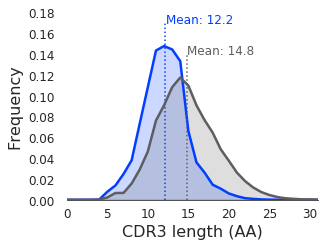

In [28]:
#Plot
cdr3_length_histogram(norm_average_cdrh3_df, color_dict, cdr3_line_dict, cdr3_text_dict,
                      ylim=(0, .18), xlim=(0, 30.99),
                      shade=True, figsize=(4.5, 3.45),
                      legend=False, style='white',
                      figfile='./figures/figure2a'
                     )

## N1 length distribution 

To examine the differences in N1 length distributions between the two species we calculate the average distribution for each repertoire (OmniRat and Human) and plot it with a line graph.

In [6]:
# Load the OmniRat Data
rat_n1_df = pd.read_csv('../Data/omnirat_n1_reads.csv', index_col=0)

# List the Human Data files
human_dfs = [file for file in os.listdir('../Data/') if 'n1len.csv' in file]

# Load the files into a dictionary 
human_n1_data = {}
for file in human_dfs:
    subject = file.split('_')[0]
    df = pd.read_csv('../Data/' + file, index_col=0)
    #df = df.drop(['-'])
    df[subject] = df.sum(axis=1)
    human_n1_data[subject] = df[subject]
# and make a DataFrame
human_n1_df = pd.DataFrame(human_n1_data).fillna(0)

# Combine rat and human DFs
rat_and_human_n1_df = human_n1_df.join(rat_n1_df).fillna(0)

# Scale and normalize the data
norm_n1_df = scale_and_normalize(rat_and_human_n1_df)

# Make a new dataframe which has N1 length distribution averages across all of the timepoints
average_n1_df = pd.DataFrame()
#average_cdrh3_df['OmniRat LN'] = norm_n1_df['OR1 LN'] + norm_n1_df['OR2 LN'] + norm_n1_df['OR3 LN']
average_n1_df['OmniRat Spleen'] = norm_n1_df['OR1 Spleen'] + norm_n1_df['OR2 Spleen'] + norm_n1_df['OR3 Spleen']
average_n1_df['Human'] = norm_n1_df['D103'] + norm_n1_df['327059'] + norm_n1_df['326907'] + norm_n1_df['326797'] + norm_n1_df['326780'] + norm_n1_df['316188']+ norm_n1_df['326737']+ norm_n1_df['326713']+ norm_n1_df['326651']+ norm_n1_df['326650']

# Calculate the frequencies for each length
norm_average_n1_df = average_n1_df / average_n1_df.sum()

/gpfs/ims/home/cjoyce/tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


In [7]:
vd_text_dict = {'Human': 0.12, 
             'OmniRat Spleen': 0.17}
vd_line_dict = {'Human': 0.3, 
             'OmniRat Spleen': 0.425}

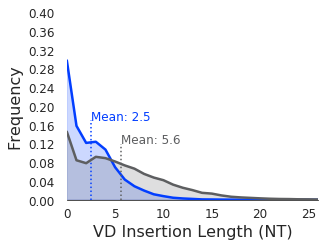

In [8]:
n_length_histogram(norm_average_n1_df, color_dict, vd_line_dict, vd_text_dict,
                      ylim=(0, .4), xlim=(0, 25.99),
                      shade=True, figsize=(4.5, 3.45),
                      legend=False, style='white',
                      xlab='VD Insertion Length (NT)', figfile='./figures/figure2b'
                     )

## N2 length distribution 

To examine the differences in N2 length distributions between the two species we calculate the average distribution for each repertoire (OmniRat and Human) and plot it with a line graph.

In [9]:
# Load the OmniRat Data
rat_n2_df = pd.read_csv('../Data/omnirat_n2_reads.csv', index_col=0)

# List the Human Data files
human_dfs = [file for file in os.listdir('../Data/') if 'n2len.csv' in file]

# Load the files into a dictionary 
human_n2_data = {}
for file in human_dfs:
    subject = file.split('_')[0]
    df = pd.read_csv('../Data/' + file, index_col=0)
    #df = df.drop(['-'])
    df[subject] = df.sum(axis=1)
    human_n2_data[subject] = df[subject]
# and make a DataFrame
human_n2_df = pd.DataFrame(human_n2_data).fillna(0)

# Combine rat and human DFs
rat_and_human_n2_df = human_n2_df.join(rat_n2_df).fillna(0)

# Scale and normalize the data
norm_n2_df = scale_and_normalize(rat_and_human_n2_df)

# Make a new dataframe which has N2 length distribution averages across all of the timepoints
average_n2_df = pd.DataFrame()
#average_cdrh3_df['OmniRat LN'] = norm_n2_df['OR1 LN'] + norm_n2_df['OR2 LN'] + norm_n2_df['OR3 LN']
average_n2_df['OmniRat Spleen'] = norm_n2_df['OR1 Spleen'] + norm_n2_df['OR2 Spleen'] + norm_n2_df['OR3 Spleen']
average_n2_df['Human'] = norm_n2_df['D103'] + norm_n2_df['327059'] + norm_n2_df['326907'] + norm_n2_df['326797'] + norm_n2_df['326780'] + norm_n2_df['316188']+ norm_n2_df['326737']+ norm_n2_df['326713']+ norm_n2_df['326651']+ norm_n2_df['326650']

# Calculate the frequencies for each length
norm_average_n2_df = average_n2_df / average_n2_df.sum()

/gpfs/ims/home/cjoyce/tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


In [10]:
dj_text_dict = {'Human': 0.12, 
             'OmniRat Spleen': 0.17}
dj_line_dict = {'Human': 0.3, 
             'OmniRat Spleen': 0.425}

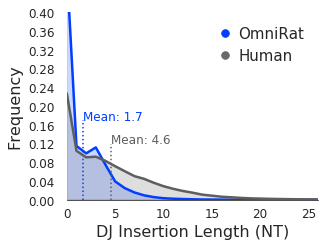

In [14]:
n_length_histogram(norm_average_n2_df, color_dict, dj_line_dict, dj_text_dict,
                      ylim=(0, .4), xlim=(0, 25.99),
                      shade=True, figsize=(4.5, 3.45),
                      legend=True, style='white',
                      xlab='DJ Insertion Length (NT)', figfile='./figures/figure2c'
                     )

## D3- J6 frequencies
To examine the difference in frequencies of antibodies with the D3-J6 gene combination (which is important in the generation of long CDRH3s) we plot a bar chart of the D3-J6 frequency differences between the two species.

In [15]:
# load the data
omnirat_dj_df = pd.read_csv('../Data/omnirat_dj_reads.csv', index_col=0)
human_dj_df = pd.read_csv('../Data/human_dj_reads.csv', index_col=0)

# Combine the data
dj_df = omnirat_dj_df.join(human_dj_df).fillna(0)

# Normalization
dj_df_norm = scale_and_normalize(dj_df)

# Get the frequencies
dj_df_freq = dj_df_norm / dj_df_norm.sum()

In [16]:
#Make a new DataFrame with only D3-J6 Frequencies
dj_fig_data = []
for subject in dj_df_freq.columns:
    if 'OR' in subject:
        species = 'OmniRat'
    else:
        species = 'Human'
    dj_fig_data.append({'Species': species, 'Frequency': dj_df_freq[subject]['IGHD3_IGHJ6'], 'Subject': subject})

dj_fig_df = pd.DataFrame(dj_fig_data)

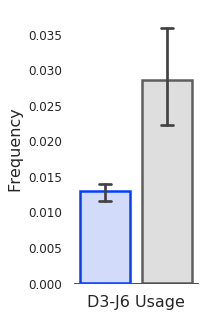

In [17]:
#Plot
plt.figure(figsize=(3,4.5))
ax = sns.barplot(data=dj_fig_df, x='Species', y='Frequency', palette=['#CCD8FF', '#DEDEDF'],
                 linewidth=2.5, edgecolor=[(0.00784313725490196, 0.24313725490196078, 1.0), '#5d5e60'], capsize=.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#sns.stripplot(data=dj_fig_df, x='Species', y='Frequency')
ax.set_ylim(0.0,0.038)
#ax.set_yticks(np.arange(0, 0.05, 0.01))
ax.set(xticklabels=[''])
ax.set_ylabel('Frequency', fontsize=16, labelpad=6)
ax.set_xlabel('D3-J6 Usage', fontsize=16)
#ax.tick_params(axis='x', which='major', labelsize=tick_fontsize)
ax.tick_params(axis='y', which='major', labelsize=12, length=6, width=1.25, pad=6, right=False)
plt.tight_layout()
plt.savefig('./figures/figure2d', dpi=800)

plt.show()

## Native D gene lengths
To examine the differences in average lengths of the D genes from wild-type species (*Rattus norvegicus*, and *Homo sapiens*) we calculate the average length of D genes for each species from data found at [**imgt.org/genedb**](http://www.imgt.org/genedb/).

In [18]:
# Read the fasta files from IMGT for each species

d_gene_lens = []

# human
for record in SeqIO.parse("../Data/human_dgenes.fasta", "fasta"):
    d_gene_lens.append({'Species': 'Human', 'D Gene Length (NT)': len(record.seq), 
                           'Family': record.id.split('IGHD')[1].split('-')[0]})
# rat
for record in SeqIO.parse("../Data/rat_dgenes.fasta", "fasta"):
    d_gene_lens.append({'Species': 'Rat', 'D Gene Length (NT)': len(record.seq), 
                           'Family': record.id.split('IGHD')[1].split('-')[0]})
# Make a DataFrame
d_gene_lens_df = pd.DataFrame(d_gene_lens)

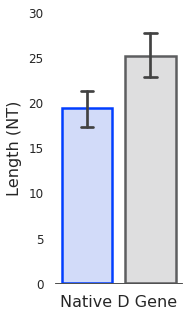

In [19]:

#Plot
plt.figure(figsize=(2.77777778,4.5))
ax = sns.barplot(data=d_gene_lens_df, x='Species', y='D Gene Length (NT)', palette=['#CCD8FF', '#DEDEDF'],
                 linewidth=2.5, edgecolor=[(0.00784313725490196, 0.24313725490196078, 1.0), '#5d5e60'], 
                 capsize=.2, order=['Rat', 'Human'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#sns.stripplot(data=dj_fig_df, x='Species', y='Frequency')
ax.set_ylim(16,28)
ax.set_yticks(np.arange(0, 35, 5))
ax.set(xticklabels=[''])
ax.set_ylabel('Length (NT)', fontsize=16, labelpad=6)
ax.set_xlabel('Native D Gene', fontsize=16)
#ax.tick_params(axis='x', which='major', labelsize=tick_fontsize)
ax.tick_params(axis='y', which='major', labelsize=12, length=6, width=1.25, pad=6, right=False)
plt.tight_layout()
#plt.savefig('./figures/figure2e', dpi=800)
plt.show()

## Frequency of given CDRH3 length or longer
To examine the difference in long CDRH3 usage.

In [20]:
minval = 0.000001

dfs = {'Human': human_df / human_df.sum().fillna(0),
       'OmniRat': rat_df/ rat_df.sum().fillna(0),}

data = []
for length in [20, 25, 30]:
    for species in dfs.keys():
        df = dfs[species]
        try:
            d = df.loc[range(length, 50)].sum()
        except KeyError:
            d = [0.0] * len(df.columns.values)
        for val in list(d):
            data.append({'x': length, 'y': val, 'species': species})

data_df = pd.DataFrame(data).replace(0.0, minval)

/gpfs/ims/home/cjoyce/tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  # This is added back by InteractiveShellApp.init_path()


In [21]:
color_dict = {s: c for s, c in zip(['Human', 'OmniRat'], ['#5d5e60', (0.00784313725490196, 0.24313725490196078, 1.0)])}
edgecolors = [color_dict[sp] for sp in data_df['species']]
mean_lengths = {20: 0,
                25: 1,
                30: 2.0}

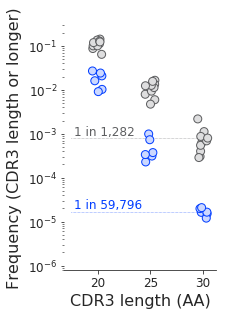

In [23]:
sns.set_style("ticks")
fig = plt.figure(figsize=[3.25, 4.5])

sns.stripplot(x="x", y="y", hue='species', data=data_df, jitter=True, size=8, 
              palette=['#DEDEDF', '#CCD8FF'],
              edgecolor=edgecolors, 
              linewidth=1)
#plt.plot([-40, 40], [minval, minval], 'k:', alpha=0.6)

# plt.text(-0.45, 1.2 * minval, 'detection limit', ha='left', alpha=0.6)

for length in [30]:
    for species in ['Human', 'OmniRat']:
        mean_y = data_df[(data_df.species == species) & (data_df.x == length)]['y'].mean()
        plt.plot([-0.5, mean_lengths[length]], [mean_y, mean_y], c=color_dict[species], ls=':', lw=0.5)
        one_in = "{:,}".format(int(1 / mean_y))
        plt.text(x=-0.45, y=1.2 * mean_y, s='1 in {}'.format(one_in), color=color_dict[species], size=12, zorder=10)
    
ax = plt.gca()

ax.set_xlabel('CDR3 length (AA)', fontsize=16)
ax.set_ylabel('Frequency (CDR3 length or longer)', fontsize=16, labelpad=6)
ax.get_legend().remove()


ax.set_yscale("log", nonposy='clip')
ax.set_ylim([0.8 * minval, 0.3])

ax.tick_params(axis='both', which='major', labelsize=12)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)



plt.tight_layout()

plt.savefig('./figures/figure2f.png', dpi=800)

plt.show()